In [85]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from evaluate import evaluate_holdout

In [86]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_coverage_data = pd.read_csv(f"{input_path}/scaled/coverage.csv")
encoded_coverage_data  = pd.read_csv(f"{input_path}/encoded/coverage.csv")
catboost_coverage_data = pd.read_csv(f"{input_path}/catboost/coverage.csv")

In [87]:
# Разделение признаков и целевой переменной
X_scaled = scaled_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_scaled = scaled_coverage_data["experiment.results.coverage.value"]

X_encoded  = encoded_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_encoded  = encoded_coverage_data["experiment.results.coverage.value"]

X_catboost = catboost_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_catboost = catboost_coverage_data["experiment.results.coverage.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

In [88]:
# Достаём scale  и mean для обратного преобразования
df = pd.read_csv(f"{input_path}/scaled/full.csv")
column_name = "experiment.results.coverage.value"
column_index = df.columns.get_loc(column_name)

scaler = joblib.load(f"{input_path}/scaled/std_scaler.joblib")
scale = scaler.scale_[column_index]
mean = scaler.mean_[column_index]

In [89]:
# Разделение данных на тренеровочную и тестовую выборки
TEST_SIZE = 0.2
GROUPS_SIZE = 10
# 367, 132, 978
RANDOM_STATE = 978
num_groups = len(X_scaled) // GROUPS_SIZE

# SVR, MLR
X_groups_scaled = np.array_split(X_scaled, num_groups)
y_groups_scaled = np.array_split(y_scaled, num_groups)

X_groups_scaled_train, X_groups_scaled_test, y_groups_scaled_train, y_groups_scaled_test = train_test_split(
    X_groups_scaled, y_groups_scaled, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_scaled_train = pd.concat(X_groups_scaled_train, ignore_index=True)
X_scaled_test = pd.concat(X_groups_scaled_test, ignore_index=True)
y_scaled_train = pd.concat(y_groups_scaled_train, ignore_index=True)
y_scaled_test = pd.concat(y_groups_scaled_test, ignore_index=True)

# RF, GBR, XGBoost
X_groups_encoded = np.array_split(X_encoded, num_groups)
y_groups_encoded = np.array_split(y_encoded, num_groups)

X_groups_encoded_train, X_groups_encoded_test, y_groups_encoded_train, y_groups_encoded_test = train_test_split(
    X_groups_encoded, y_groups_encoded, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_encoded_train = pd.concat(X_groups_encoded_train, ignore_index=True)
X_encoded_test = pd.concat(X_groups_encoded_test, ignore_index=True)
y_encoded_train = pd.concat(y_groups_encoded_train, ignore_index=True)
y_encoded_test = pd.concat(y_groups_encoded_test, ignore_index=True)


# CatBoost
X_groups_catboost = np.array_split(X_catboost, num_groups)
y_groups_catboost = np.array_split(y_catboost, num_groups)

X_groups_catboost_train, X_groups_catboost_test, y_groups_catboost_train, y_groups_catboost_test = train_test_split(
    X_groups_catboost, y_groups_catboost, test_size = TEST_SIZE, random_state = RANDOM_STATE
)

X_catboost_train = pd.concat(X_groups_catboost_train, ignore_index=True)
X_catboost_test = pd.concat(X_groups_catboost_test, ignore_index=True)
y_catboost_train = pd.concat(y_groups_catboost_train, ignore_index=True)
y_catboost_test = pd.concat(y_groups_catboost_test, ignore_index=True)
RANDOM_STATE


p:\GitHub\Darknessich\UASSML\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
p:\GitHub\Darknessich\UASSML\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


978

In [90]:
groups_ids = np.repeat(np.arange(len(X_scaled_train) // GROUPS_SIZE), GROUPS_SIZE)
# Кросс-валидация
cv = GroupKFold(n_splits=10, shuffle=True, random_state=0)

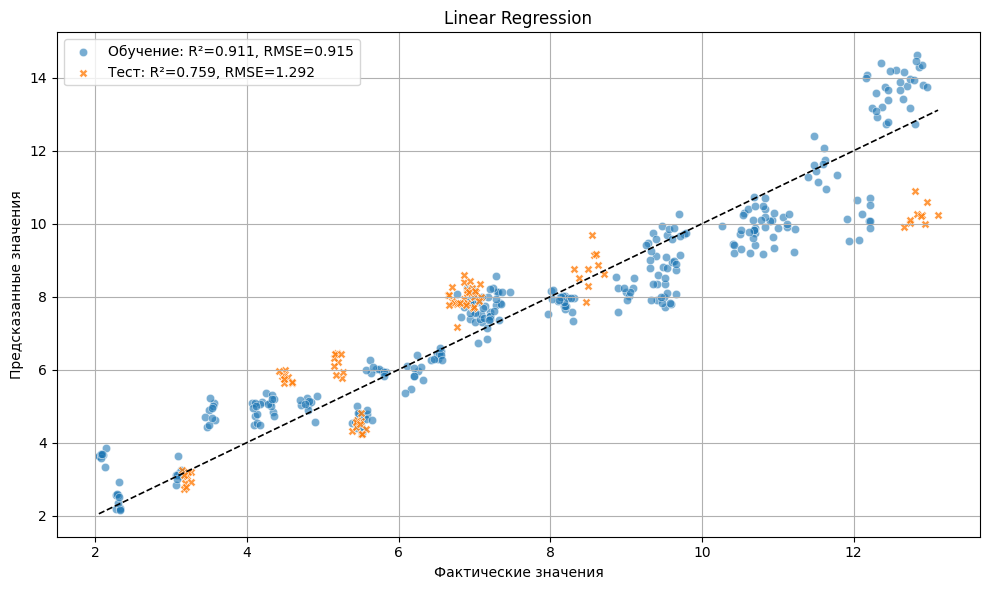

In [91]:
results["LinearRegression"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test, 
    LinearRegression(), "Linear Regression",
    scale=scale, mean=mean
)

In [92]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled_train, y_scaled_train, groups=groups_ids)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'C': np.float64(1.0), 'epsilon': np.float64(0.1), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.6737567924444224


In [93]:
# Подбор гиперпараметров для SVR
kernel = grid_search.best_params_['kernel']
gamma = grid_search.best_params_['gamma']
lgC = np.log10(grid_search.best_params_['C'])
lge = np.log10(grid_search.best_params_['epsilon'])

param_grid = {
    'kernel': [kernel], 
    'C': np.logspace(lgC - 1, lgC + 1, 40),        
    'epsilon': np.logspace(lge - 1, lge + 1, 40),
    'gamma': [gamma]
}

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled_train, y_scaled_train, groups=groups_ids)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits


Best parameters: {'C': np.float64(1.7012542798525891), 'epsilon': np.float64(0.24244620170823283), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.7098694192609614


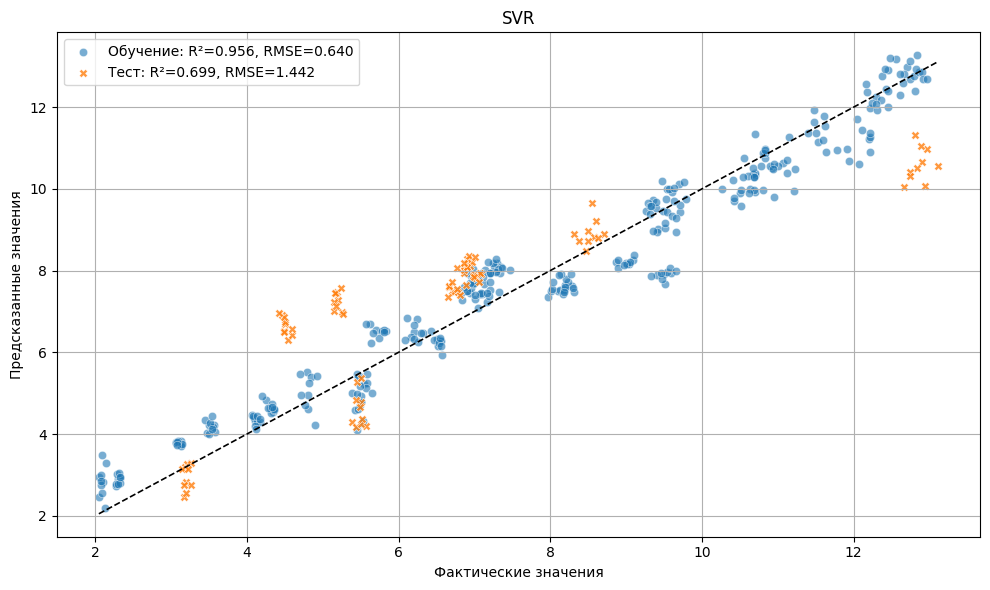

In [94]:
results["SVR"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test,
    SVR(**grid_search.best_params_), "SVR",
    scale=scale, mean=mean
)

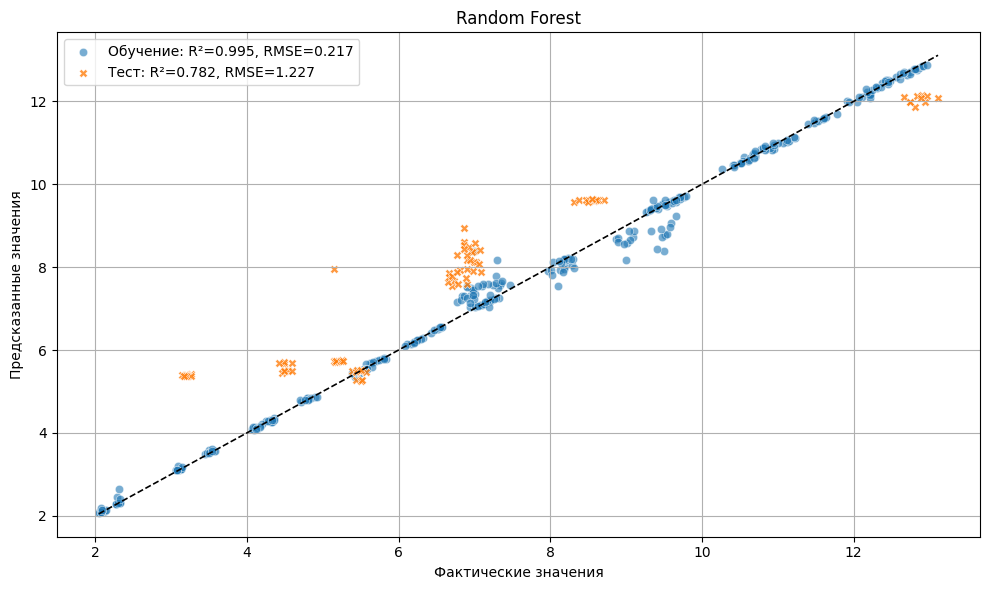

In [95]:
results["RandomForest"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    RandomForestRegressor(), "Random Forest"
)

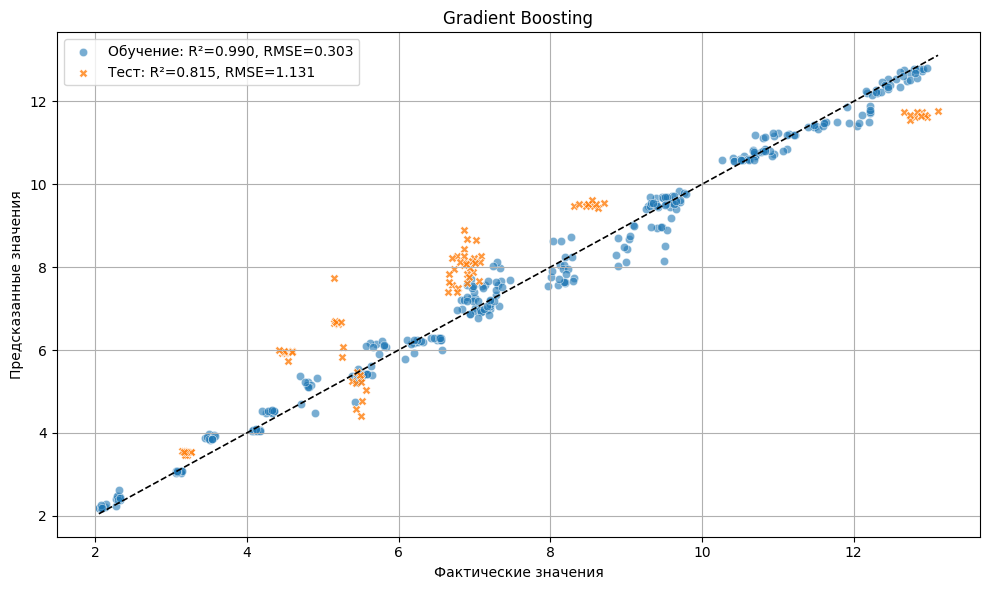

In [96]:
results["GradientBoosting"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    GradientBoostingRegressor(), "Gradient Boosting"
)

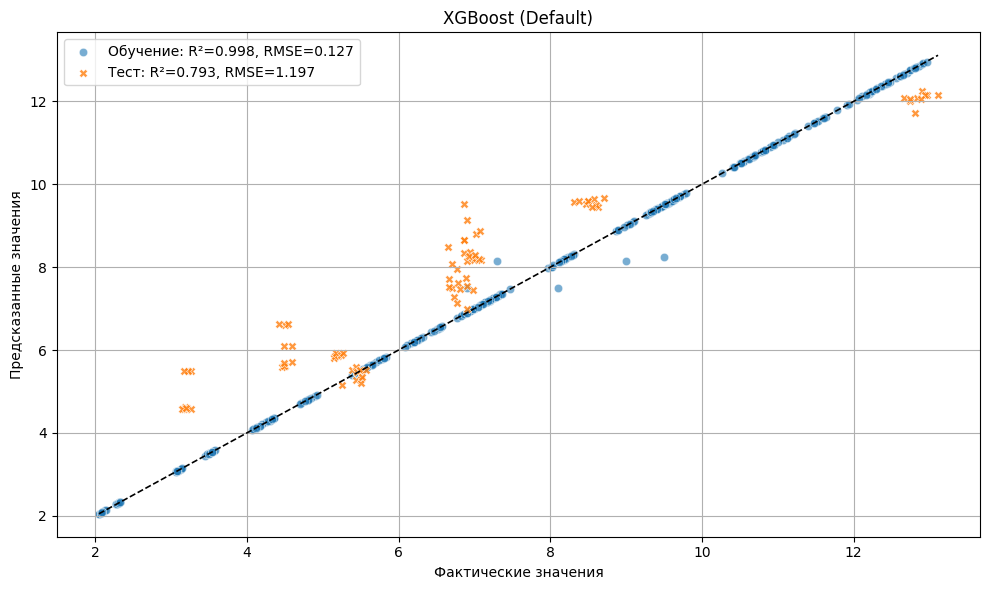

In [102]:
results["XGBoost (Default)"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(), "XGBoost (Default)",
)

In [98]:
# Параметры для подбора XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'subsample': Continuous(0.5, 1.0),
    'colsample_bytree': Continuous(0.5, 1.0),
    'gamma': Continuous(0, 5),
    'reg_alpha': Continuous(0, 2),
    'reg_lambda': Continuous(0, 2),
}

cv_splits = list(cv.split(X_encoded_train, y_encoded_train, groups=groups_ids))

# Генетический поиск
evolved_search = GASearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=0),
    cv=cv_splits,
    scoring='r2',
    param_grid=param_grid,
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

# Обучение
evolved_search.fit(X_encoded_train, y_encoded_train)

# Лучшие параметры
print("Best parameters:", evolved_search.best_params_)
print("Best R2 score (CV):", evolved_search.best_score_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.357224	0.142387   	0.589571   	-0.00380533


1  	60    	0.454993	0.088275   	0.589571   	0.260919   
2  	60    	0.519666	0.0751814  	0.594136   	0.270252   
3  	60    	0.540916	0.0560627  	0.602988   	0.37367    
4  	60    	0.57127 	0.0437306  	0.602988   	0.426885   
5  	60    	0.582912	0.0370546  	0.641376   	0.470123   
6  	60    	0.581307	0.0419214  	0.641376   	0.462884   
7  	60    	0.606934	0.0275011  	0.682726   	0.544882   
8  	60    	0.615411	0.0477747  	0.683111   	0.394884   
9  	60    	0.631747	0.0360763  	0.690003   	0.510473   
10 	60    	0.649934	0.0296072  	0.690003   	0.584474   
11 	60    	0.660012	0.0235095  	0.690003   	0.622497   
12 	60    	0.648679	0.0719977  	0.690003   	0.295002   
13 	60    	0.66151 	0.0325248  	0.690003   	0.531419   
14 	60    	0.635506	0.0808279  	0.690003   	0.34018    
15 	60    	0.66373 	0.0199652  	0.690003   	0.624549   
16 	60    	0.668613	0.0195872  	0.690003   	0.613173   
17 	60    	0.676563	0.0164137  	0.690003   	0.623555   
18 	60    	0.679471	0.022415   	0.697829   	0.59

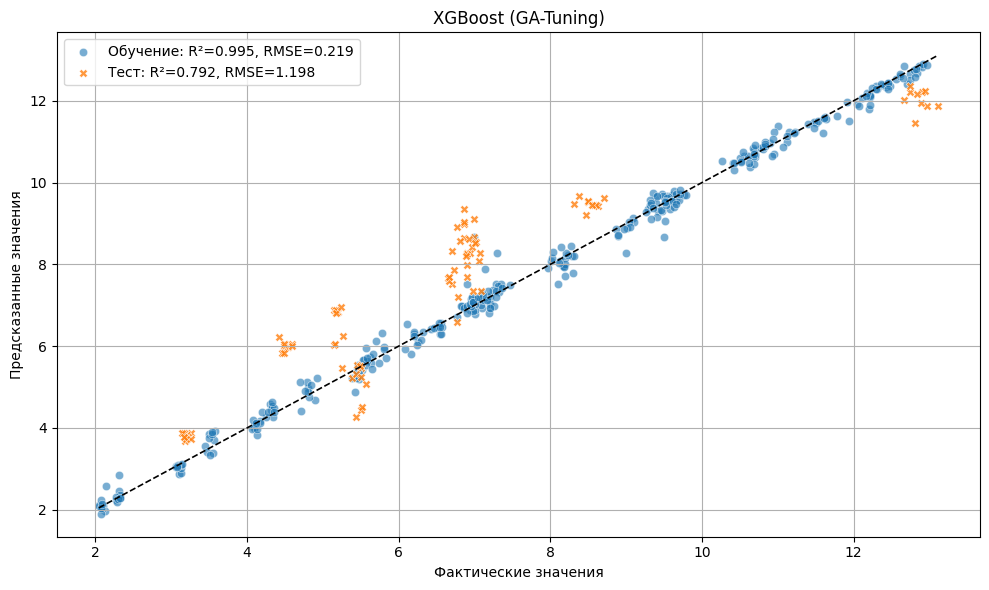

In [99]:
results["XGBoost (GA-Tuning)"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(**evolved_search.best_params_), "XGBoost (GA-Tuning)"
)

Learning rate set to 0.034364
0:	learn: 2.9859670	total: 64.6ms	remaining: 1m 4s
1:	learn: 2.9108282	total: 131ms	remaining: 1m 5s
2:	learn: 2.8419711	total: 191ms	remaining: 1m 3s
3:	learn: 2.7755620	total: 255ms	remaining: 1m 3s
4:	learn: 2.7149656	total: 305ms	remaining: 1m
5:	learn: 2.6564265	total: 383ms	remaining: 1m 3s
6:	learn: 2.5892308	total: 428ms	remaining: 1m


7:	learn: 2.5287237	total: 468ms	remaining: 58s
8:	learn: 2.4705053	total: 508ms	remaining: 55.9s
9:	learn: 2.4130578	total: 543ms	remaining: 53.7s
10:	learn: 2.3610018	total: 582ms	remaining: 52.4s
11:	learn: 2.3039514	total: 621ms	remaining: 51.2s
12:	learn: 2.2526330	total: 662ms	remaining: 50.2s
13:	learn: 2.2030339	total: 701ms	remaining: 49.4s
14:	learn: 2.1540435	total: 742ms	remaining: 48.7s
15:	learn: 2.1086131	total: 779ms	remaining: 47.9s
16:	learn: 2.0644405	total: 848ms	remaining: 49s
17:	learn: 2.0199921	total: 926ms	remaining: 50.5s
18:	learn: 1.9783400	total: 974ms	remaining: 50.3s
19:	learn: 1.9423604	total: 1s	remaining: 49.1s
20:	learn: 1.8995629	total: 1.05s	remaining: 48.9s
21:	learn: 1.8606329	total: 1.09s	remaining: 48.7s
22:	learn: 1.8226509	total: 1.14s	remaining: 48.5s
23:	learn: 1.7918823	total: 1.2s	remaining: 48.9s
24:	learn: 1.7586575	total: 1.26s	remaining: 49.1s
25:	learn: 1.7184026	total: 1.32s	remaining: 49.4s
26:	learn: 1.6875539	total: 1.38s	remainin

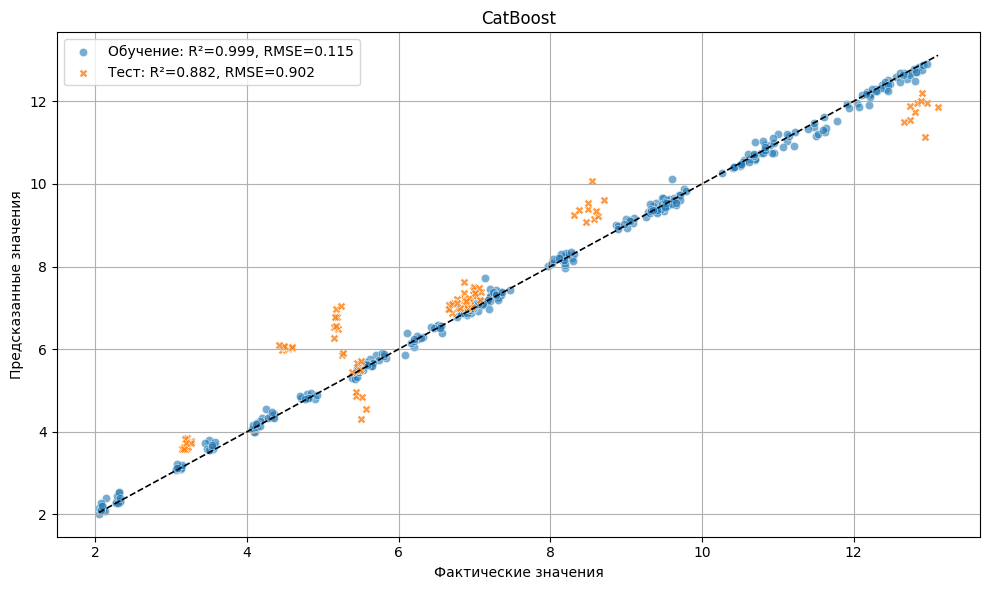

In [100]:
results["CatBoost"] = evaluate_holdout(
    X_catboost_train, X_catboost_test,
    y_catboost_train, y_catboost_test, 
    CatBoostRegressor(), "CatBoost",
    cat_features=catboost_features
)

In [103]:
results_df = pd.DataFrame(results)
results_df = results_df.T.reset_index().rename(columns={'index': 'Модель'})
results_df = results_df.sort_values("r2_test", ascending=False).reset_index(drop=True)
results_df = results_df.rename(columns={
    "model":      "Модель",
    "r2_train":   "R² обуч.",
    "rmse_train": "RMSE обуч.",
    "r2_test":    "R² тест.",
    "rmse_test":  "RMSE тест."
})

results_df

,Модель,R² обуч.,RMSE обуч.,R² тест.,RMSE тест.
0,CatBoost,0.998585,0.115213,0.882371,0.901760
1,GradientBoosting,0.990218,0.302911,0.814927,1.131111
2,XGBoost (Default),0.998290,0.126628,0.792790,1.196849
3,XGBoost (GA-Tuning),0.994903,0.218646,0.792265,1.198363
4,RandomForest,0.994976,0.217081,0.782113,1.227295
5,LinearRegression,0.910811,0.914635,0.758507,1.292069
6,SVR,0.956363,0.639769,0.699309,1.441762


In [109]:
# Важнейшие признаки CatBoost
model = CatBoostRegressor()
model.fit(X_catboost_train, y_catboost_train, cat_features=catboost_features, verbose=0)

importances = model.get_feature_importance()
feature_names = X_catboost_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.1f}")

experiment.params.spray_volume: 65.5
experiment.params.flight_speed: 8.0
experiment.weather.humidity.min: 3.4
model.nozzles.number: 2.1
experiment.weather.humidity.max: 2.0
experiment.weather.velocity.max: 1.8
experiment.weather.temperature.min: 1.7
experiment.weather.velocity.min: 1.6
experiment.params.height: 1.5
model.rotors.power: 1.5
model.swath_width.max: 1.2
plant.phenotypes.leaf_area: 1.2
experiment.weather.temperature.max: 0.8
plant.phenotypes.orthotropic_branch_length: 0.8
plant.phenotypes.plagiotropic_node_distance: 0.7
model.weight: 0.6
experiment.params.flow_rate: 0.6
model.rotors.number: 0.6
plant.phenotypes.plagiotropic_node_number: 0.5
model.dimensions.length: 0.5
plant.phenotypes.diameter: 0.5
model.particle_diameter.max: 0.4
experiment.params.atomization_diameter: 0.4
plant.phenotypes.height: 0.4
model.water_pump.number: 0.4
plant.phenotypes.orthotropic_branch_node_number: 0.3
model.water_pump.type: 0.2
model.water_pump.flow_rate: 0.2
model.name: 0.1
plant.cultivar: 0

In [110]:
# Важнейшие признаки GradientBoosting
model = GradientBoostingRegressor()
model.fit(X_encoded_train, y_encoded_train)

importances = model.feature_importances_
feature_names = X_encoded_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance*100:.1f}")

experiment.params.spray_volume: 76.9
experiment.weather.temperature.min: 9.4
experiment.params.flight_speed: 6.8
experiment.weather.humidity.max: 1.0
experiment.weather.velocity.min: 1.0
experiment.params.height: 0.7
model.nozzles.number: 0.6
experiment.weather.humidity.min: 0.6
model.nozzles.type_SX11001VS: 0.6
experiment.params.atomization_diameter_fine: 0.6
experiment.weather.temperature.max: 0.4
experiment.params.atomization_diameter_medium: 0.4
experiment.weather.velocity.max: 0.3
experiment.params.atomization_diameter_off: 0.2
experiment.params.atomization_diameter_coarse: 0.1
model.name_AGRAS T40: 0.1
model.nozzles.type_LX8060SZ: 0.1
model.name_AGRAS T20: 0.0
model.tank_volume: 0.0
plant.name_wheat: 0.0
model.rotors.number: 0.0
plant.name_coffee: 0.0
plant.name_tea: 0.0
model.name_AGRAS T30: 0.0
model.name_JT5L-404: 0.0
model.nozzles.type_XR110015: 0.0
model.nozzles.type_full cone: 0.0


In [111]:
# Важнейшие признаки XGBoost (Default)
model = XGBRegressor()
model.fit(X_encoded_train, y_encoded_train)

importances = model.feature_importances_
feature_names = X_encoded_train.columns
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance*100:.1f}")

experiment.params.spray_volume: 57.6
model.nozzles.number: 18.5
experiment.params.atomization_diameter_fine: 7.5
experiment.weather.temperature.min: 6.4
model.tank_volume: 5.8
experiment.params.flight_speed: 1.7
experiment.params.height: 0.5
experiment.weather.velocity.max: 0.5
experiment.params.atomization_diameter_medium: 0.4
experiment.weather.humidity.max: 0.3
experiment.params.atomization_diameter_coarse: 0.2
experiment.weather.humidity.min: 0.2
experiment.weather.temperature.max: 0.2
experiment.weather.velocity.min: 0.1
model.rotors.number: 0.0
plant.name_coffee: 0.0
plant.name_tea: 0.0
plant.name_wheat: 0.0
model.name_AGRAS T20: 0.0
model.name_AGRAS T30: 0.0
model.name_AGRAS T40: 0.0
model.name_JT5L-404: 0.0
model.nozzles.type_LX8060SZ: 0.0
model.nozzles.type_SX11001VS: 0.0
model.nozzles.type_XR110015: 0.0
model.nozzles.type_full cone: 0.0
experiment.params.atomization_diameter_off: 0.0
